## Import Library

In [53]:
import matplotlib.pyplot as plt
from neuralprophet import NeuralProphet,set_log_level
import seaborn as sns
import lttbc
import ipywidgets
import pandas as pd
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')
set_log_level('ERROR')

## Loading Data

In [54]:
df=pd.read_csv('GlobalLandTemperaturesByCity.csv')
dfhk=df[df['Country']=='Hong Kong']
dfhk=dfhk[['dt', 'AverageTemperature']]
dfhk['dt']=pd.to_datetime(dfhk['dt'])
dfhk=dfhk[-157:-1]
dfhk.columns=['ds','y']
dfhk.reset_index(drop=True)

,ds,y
0,2000-09-01,26.728
1,2000-10-01,24.262
2,2000-11-01,18.370
3,2000-12-01,15.502
4,2001-01-01,14.702
...,...,...
151,2013-04-01,21.305
152,2013-05-01,25.896
153,2013-06-01,28.005
154,2013-07-01,28.431


## Train Test Split

In [55]:
test_size=int(len(dfhk)*0.2)
train=dfhk[:-test_size]
test=dfhk[-test_size:]
train.shape , test.shape

((125, 2), (31, 2))

## Modelling

### 1. Prophet
https://mkang32.github.io/python/2020/12/15/prophet-intro.html

https://facebook.github.io/prophet/docs/diagnostics.html

In [56]:
m=Prophet(yearly_seasonality=True)
m.fit(train)
future = m.make_future_dataframe(periods=test_size,freq='M')
forecast = m.predict(future)


09:02:56 - cmdstanpy - INFO - Chain [1] start processing
09:02:56 - cmdstanpy - INFO - Chain [1] done processing


#### Components

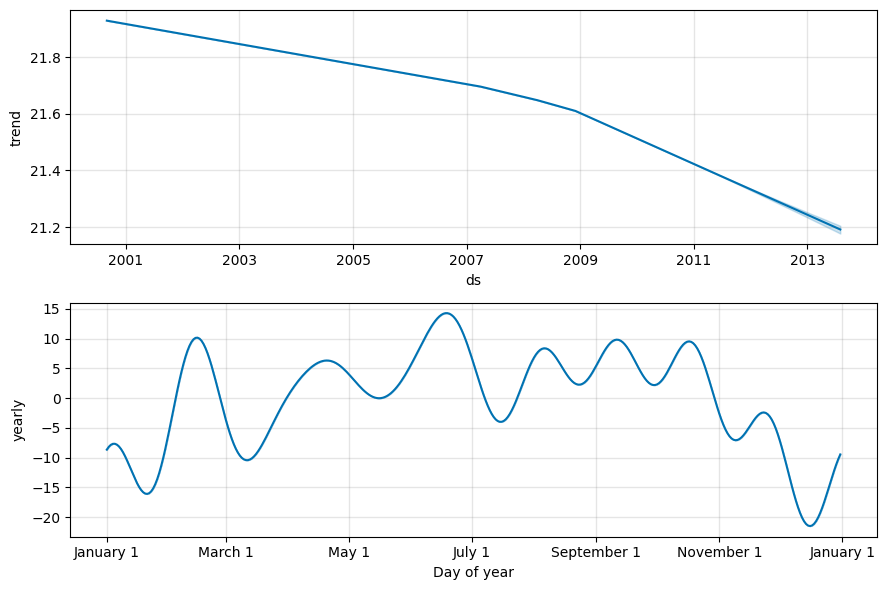

In [57]:
fig2 = m.plot_components(forecast)

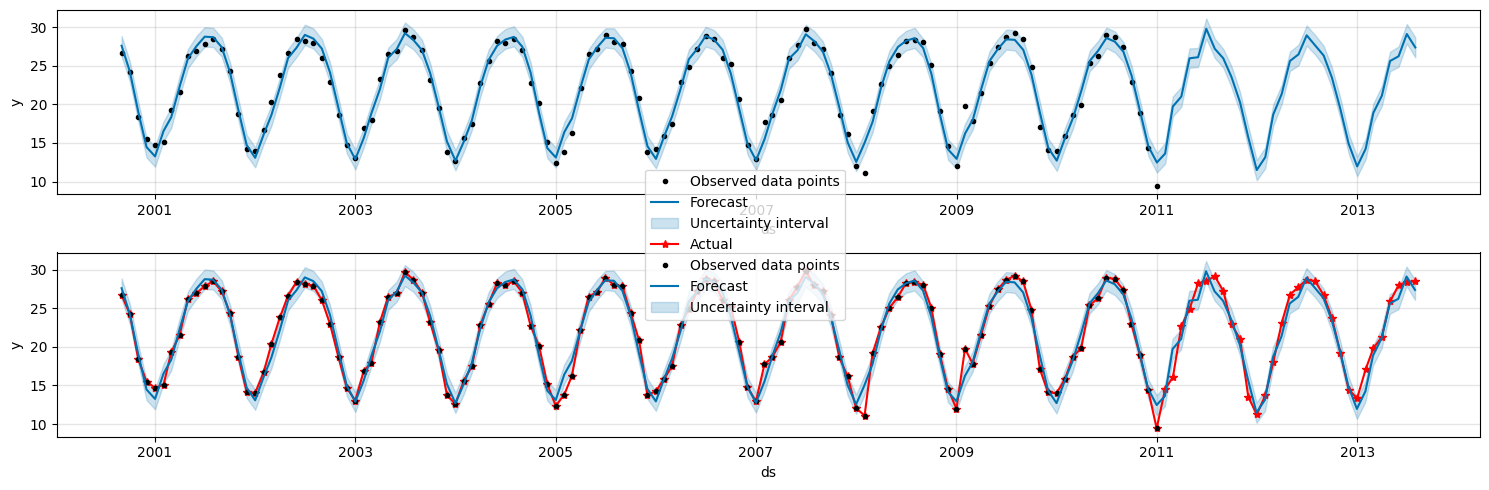

In [58]:
f, ax = plt.subplots(2)
f.set_figheight(5)
f.set_figwidth(15)
fig1 = m.plot(forecast,ax=ax[0])
ax[1].plot(dfhk['ds'], dfhk['y'], color='r',marker='*',label='Actual')
fig = m.plot(forecast, ax=ax[1])
f.legend(loc='center')
plt.show()

#### Visual Comparsion

<Axes: xlabel='ds', ylabel='yhat'>

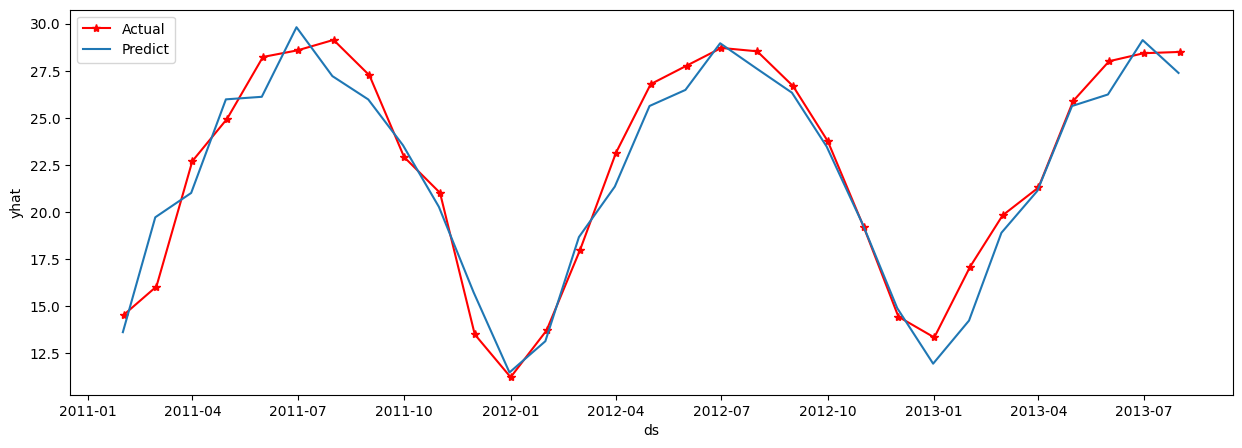

In [59]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test['ds'], test['y'], color='r',marker='*',label='Actual')
sns.lineplot(x=forecast['ds'],y=forecast[-test_size:]['yhat'],label='Predict', ax=ax)


#### Statistic Comparsion

In [60]:
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
mae_prophet_before=mean_absolute_error(forecast[-test_size:].yhat.values,test.y.values)
mape_prophet_before=round(mean_absolute_percentage_error(forecast[-test_size:].yhat.values,test.y.values)*100,3)
print('MAE: '+str(mae_prophet_before))
print('MAPE: '+str(mape_prophet_before)+'%')
summary_prophet_before=pd.DataFrame({'prediction':forecast[-test_size:].yhat.values,'test':test.y.values})
summary_prophet_before['diff']=round(summary_prophet_before.prediction-summary_prophet_before.test,1)
summary_prophet_before['diff%']=round((summary_prophet_before.prediction-summary_prophet_before.test)/summary_prophet_before.test*100,1)
summary_prophet_before['prediction']=round(summary_prophet_before['prediction'],1)
summary_prophet_before['test']=round(summary_prophet_before['test'],1)
summary_prophet_before['dt']=future['ds'][-test_size:].values
summary_prophet_before

MAE: 1.122326903095762
MAPE: 5.557%


,prediction,test,diff,diff%,dt
0,13.6,14.6,-0.9,-6.4,2011-01-31
1,19.7,16.1,3.7,22.9,2011-02-28
2,21.0,22.7,-1.7,-7.4,2011-03-31
3,26.0,24.9,1.0,4.1,2011-04-30
4,26.1,28.2,-2.1,-7.5,2011-05-31
5,29.8,28.6,1.2,4.3,2011-06-30
6,27.2,29.1,-1.9,-6.6,2011-07-31
7,26.0,27.3,-1.3,-4.7,2011-08-31
8,23.5,22.9,0.6,2.7,2011-09-30
9,20.3,21.0,-0.7,-3.5,2011-10-31


#### Hyper-parameter tuning

In [61]:
#Hyper-parameter tuning
import itertools
from prophet.diagnostics import cross_validation,performance_metrics

param_grid = {  
    'changepoint_prior_scale': [0.00092,0.000925,0.000930],
    'seasonality_prior_scale': [0.0875]
}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days',horizon='365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

09:02:58 - cmdstanpy - INFO - Chain [1] start processing
09:02:58 - cmdstanpy - INFO - Chain [1] done processing
09:02:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
09:02:58 - cmdstanpy - INFO - Chain [1] start processing
09:02:58 - cmdstanpy - INFO - Chain [1] done processing
09:03:11 - cmdstanpy - INFO - Chain [1] start processing
09:03:12 - cmdstanpy - INFO - Chain [1] done processing
09:03:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
09:03:12 - cmdstanpy - INFO - Chain [1] start processing
09:03:12 - cmdstanpy - INFO - Chain [1] done processing
09:03:18 - cmdstanpy - INFO - Chain [1] start processing
09:03:18 - cmdstanpy - INFO - Chain [1] done processing
09:03:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newto

   changepoint_prior_scale  seasonality_prior_scale      rmse
0                 0.000920                   0.0875  1.297728
1                 0.000925                   0.0875  1.297885
2                 0.000930                   0.0875  1.297197


{'changepoint_prior_scale': 0.00093, 'seasonality_prior_scale': 0.0875}


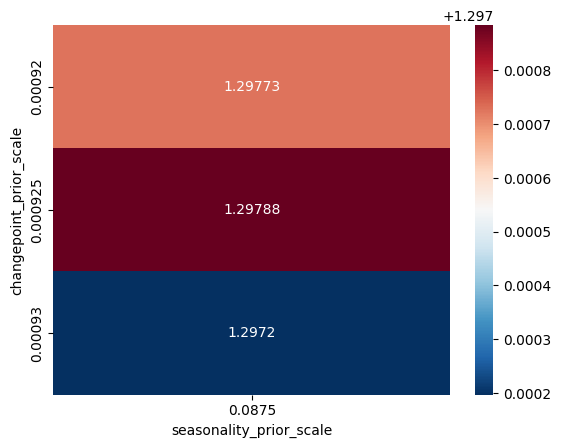

In [62]:
import numpy as np
table=pd.pivot_table(data=tuning_results,index='changepoint_prior_scale',columns='seasonality_prior_scale',values='rmse')
sns.heatmap(table,annot=True,fmt=".6",cmap="RdBu_r")
best_params = all_params[np.argmin(rmses)]
print(best_params)

In [63]:
m = Prophet(**best_params).fit(train)
forecast = m.predict(future)

09:03:24 - cmdstanpy - INFO - Chain [1] start processing
09:03:24 - cmdstanpy - INFO - Chain [1] done processing
09:03:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
09:03:24 - cmdstanpy - INFO - Chain [1] start processing
09:03:25 - cmdstanpy - INFO - Chain [1] done processing


MAE: 0.8666054345207487
MAPE: 4.405%


,prediction,test,diff,diff%,dt
0,15.0,14.6,0.4,2.8,2011-01-31
1,18.6,16.1,2.5,15.6,2011-02-28
2,21.4,22.7,-1.3,-5.8,2011-03-31
3,25.6,24.9,0.7,2.7,2011-04-30
4,26.6,28.2,-1.6,-5.7,2011-05-31
5,29.1,28.6,0.5,1.9,2011-06-30
6,28.0,29.1,-1.1,-3.9,2011-07-31
7,26.6,27.3,-0.6,-2.3,2011-08-31
8,23.8,22.9,0.8,3.6,2011-09-30
9,19.5,21.0,-1.5,-7.2,2011-10-31


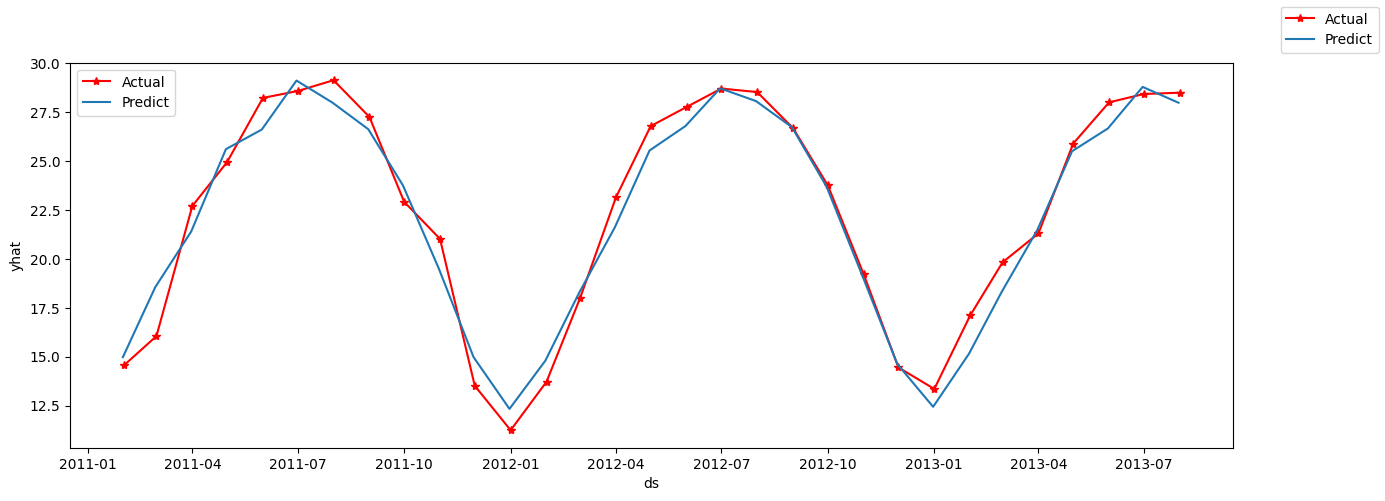

In [64]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test['ds'], test['y'], color='r',marker='*',label='Actual')
sns.lineplot(x=forecast['ds'],y=forecast[-test_size:]['yhat'],label='Predict', ax=ax)
f.legend()

from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
mae_prophet_after=mean_absolute_error(forecast[-test_size:].yhat.values,test.y.values)
mape_prophet_after=round(mean_absolute_percentage_error(forecast[-test_size:].yhat.values,test.y.values)*100,3)
print('MAE: '+str(mae_prophet_after))
print('MAPE: '+str(mape_prophet_after)+'%')
summary_prophet_after=pd.DataFrame({'prediction':forecast[-test_size:].yhat.values,'test':test.y.values})
summary_prophet_after['diff']=round(summary_prophet_after.prediction-summary_prophet_after.test,1)
summary_prophet_after['diff%']=round((summary_prophet_after.prediction-summary_prophet_after.test)/summary_prophet_after.test*100,1)
summary_prophet_after['prediction']=round(summary_prophet_after['prediction'],1)
summary_prophet_after['test']=round(summary_prophet_after['test'],1)
summary_prophet_after['dt']=future['ds'][-test_size:].values
summary_prophet_after

### Neural Prophet
https://zhuanlan.zhihu.com/p/497551815

https://zhuanlan.zhihu.com/p/333210630

In [65]:
m=NeuralProphet(yearly_seasonality=True)
metrics=m.fit(train,freq='M',epochs=100)
future = m.make_future_dataframe(train,periods=test_size)
forecast = m.predict(future)

Finding best initial lr:   0%|          | 0/208 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

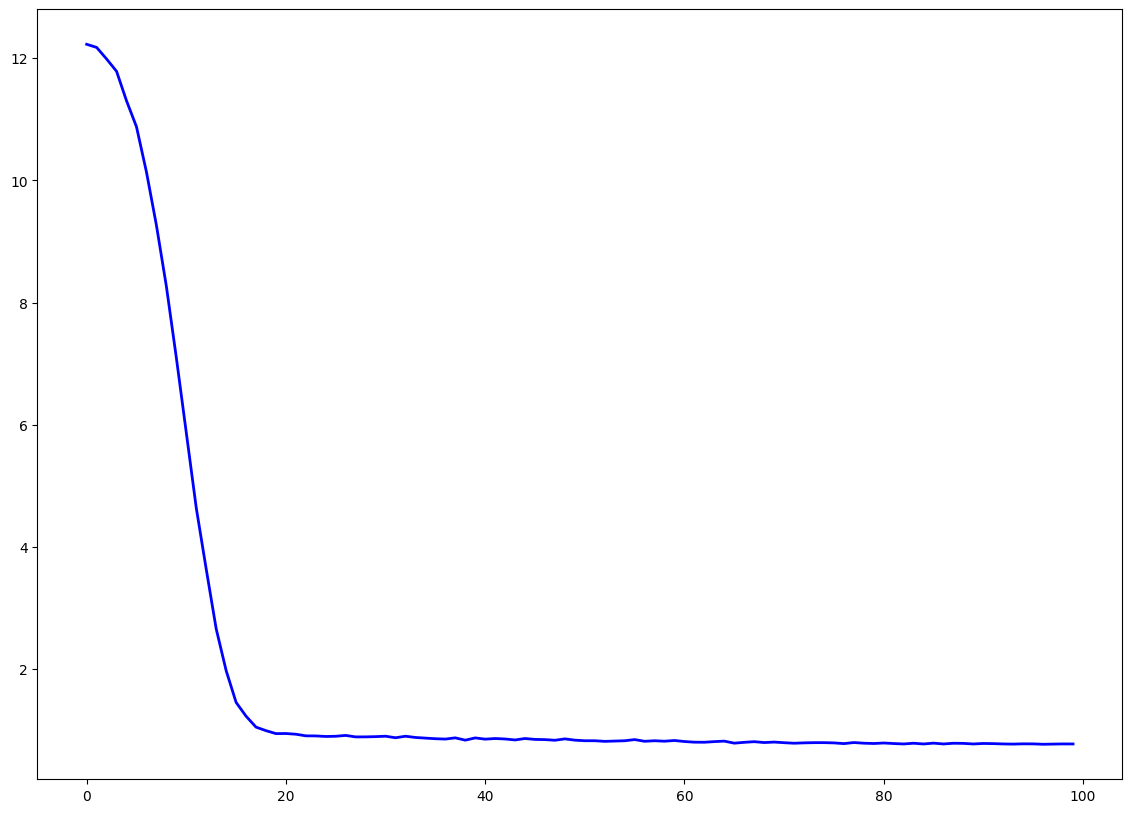

In [66]:
fig, ax = plt.subplots(figsize=(14, 10)) 
ax.plot(metrics["MAE"], 'b', linewidth=2, label="Training Loss")
#ax.plot(metrics["MAE_val"], 'r', linewidth=2, label="Training Loss")   
# You can use metrics["SmoothL1Loss"] and metrics["SmoothL1Loss_val"] too.

#### Components

In [67]:
m.plot_parameters()

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': 'Trend',
              'type': 'scatter',
              'uid': 'c1419080-7dfb-45ac-8751-97cf86d90e7d',
              'x': array([datetime.datetime(2000, 9, 1, 0, 0),
                          datetime.datetime(2000, 10, 1, 0, 0),
                          datetime.datetime(2000, 11, 1, 0, 0),
                          datetime.datetime(2000, 12, 1, 0, 0),
                          datetime.datetime(2001, 1, 1, 0, 0),
                          datetime.datetime(2001, 2, 1, 0, 0),
                          datetime.datetime(2001, 3, 1, 0, 0),
                          datetime.datetime(2001, 4, 1, 0, 0),
                          datetime.datetime(2001, 5, 1, 0, 0),
                          datetime.datetime(2001, 6, 1, 0, 0),
                          datetime.datetime(2001, 7, 1, 0, 0),
                          datetime.dat

#### Visual Comparison

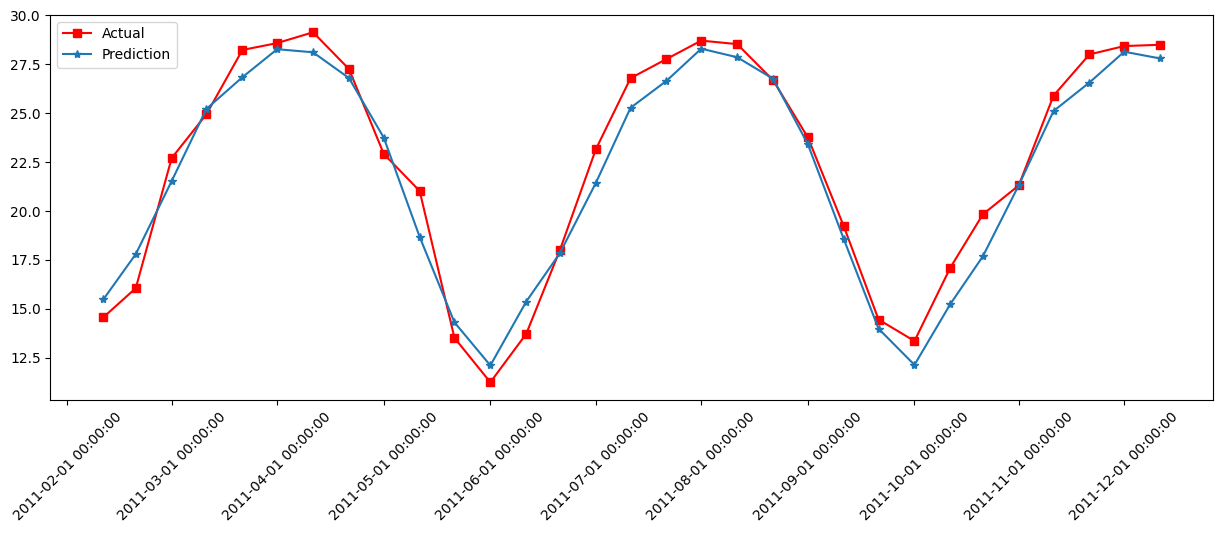

In [68]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test['ds'], test['y'], color='r',marker='s',label='Actual')
ax.plot(forecast['ds'],forecast['yhat1'],marker='*',label='Prediction')
ax.set_xticklabels(test['ds'])
plt.xticks(rotation=45)
plt.legend()

#### Statistic Comparison

In [69]:


from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
mae_n_prophet=mean_absolute_error(forecast[-test_size:].yhat1.values,test.y.values)
mape_n_prophet=round(mean_absolute_percentage_error(forecast[-test_size:].yhat1.values,test.y.values)*100,3)
print('MAE: '+str(mae_n_prophet))
print('MAPE: '+str(mape_n_prophet)+'%')
summary_n_prophet=pd.DataFrame({'prediction':forecast[-test_size:].yhat1.values,'test':test.y.values})
summary_n_prophet['diff']=round(summary_n_prophet.prediction-summary_n_prophet.test,1)
summary_n_prophet['diff%']=round((summary_n_prophet.prediction-summary_n_prophet.test)/summary_n_prophet.test*100,1)
summary_n_prophet['prediction']=round(summary_n_prophet['prediction'],1)
summary_n_prophet['test']=round(summary_n_prophet['test'],1)
summary_n_prophet['dt']=future['ds'][-test_size:].values
summary_n_prophet

MAE: 0.9474705473376862
MAPE: 4.889%


,prediction,test,diff,diff%,dt
0,15.5,14.6,0.9,6.3,2011-02-01
1,17.8,16.1,1.7,10.8,2011-03-01
2,21.5,22.7,-1.2,-5.2,2011-04-01
3,25.2,24.9,0.3,1.1,2011-05-01
4,26.8,28.2,-1.4,-4.9,2011-06-01
5,28.3,28.6,-0.3,-1.1,2011-07-01
6,28.1,29.1,-1.0,-3.5,2011-08-01
7,26.8,27.3,-0.5,-1.7,2011-09-01
8,23.7,22.9,0.8,3.6,2011-10-01
9,18.7,21.0,-2.3,-11.2,2011-11-01


### SARIMAX (Stepwise)

https://medium.com/swlh/temperature-forecasting-with-arima-model-in-python-427b2d3bcb53

#### Stationary Test

In [70]:
#Check for stationary
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:", dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
ad_test(dfhk['y'])

1. ADF :  -2.2574822652698803
2. P-Value :  0.1860475059021109
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression: 143
5. Critical Values :
	 1% :  -3.4769274060112707
	 5% :  -2.8819726324025625
	 10% :  -2.577665408088415


#### Auto_Arima

In [71]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(train['y'],trace=True,seasonal=True)


 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=788.726, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=675.851, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=630.363, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=600.342, Time=0.18 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=588.518, Time=0.12 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=651.356, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=614.010, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=597.765, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=585.633, Time=0.13 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=583.598, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=566.795, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=493.320, Time=0.31 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=472.410, Time=0.32 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=483.481, Time=0.34 sec
 ARIMA(3,0,0)(0,0,0)[1] inter

In [72]:

from statsmodels.tsa.arima.model import ARIMA
#model=ARIMA(train['y'],order=(2,0,2))
model=stepwise_fit
model=model.fit(train['y'])
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  125
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -230.205
Date:                Wed, 17 May 2023   AIC                            472.410
Time:                        09:03:37   BIC                            489.380
Sample:                             0   HQIC                           479.304
                                - 125                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.9254      0.096     61.780      0.000       5.737       6.113
ar.L1          1.7286      0.005    328.505      0.000       1.718       1.739
ar.L2         -0.9967      0.004   -227.682      0.000      -1.005      -0.988
ma.L1         -1.6166      0.077    -20.965      0.000      -1.768      -1.465
ma.L2          0.8218      0.081     10.206      0.000       0.664       0.980
sigma2         2.3645      0.282      8.390      0.000       1.812       2.917
===================================================================================
Ljung-Box (L1) (Q):                   3.80   Jarque-Bera (JB):                 5.55
Prob(Q):                              0.05   Prob(JB):                         0.06
Heteroskedasticity (H):               2.08   Skew:                            -0.10
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [73]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(test_size)

pred=pd.DataFrame(pred.values,columns=['Prediction'],index=test['ds'])
test2=test[:]
test2=test2.set_index('ds',drop=True)
test2=test2[['y']]

In [74]:
pred2=pred
pred2=pred2.reset_index()
pred2.columns=['ds','yhat1']
forecast=pred2

#### Visual Comparison

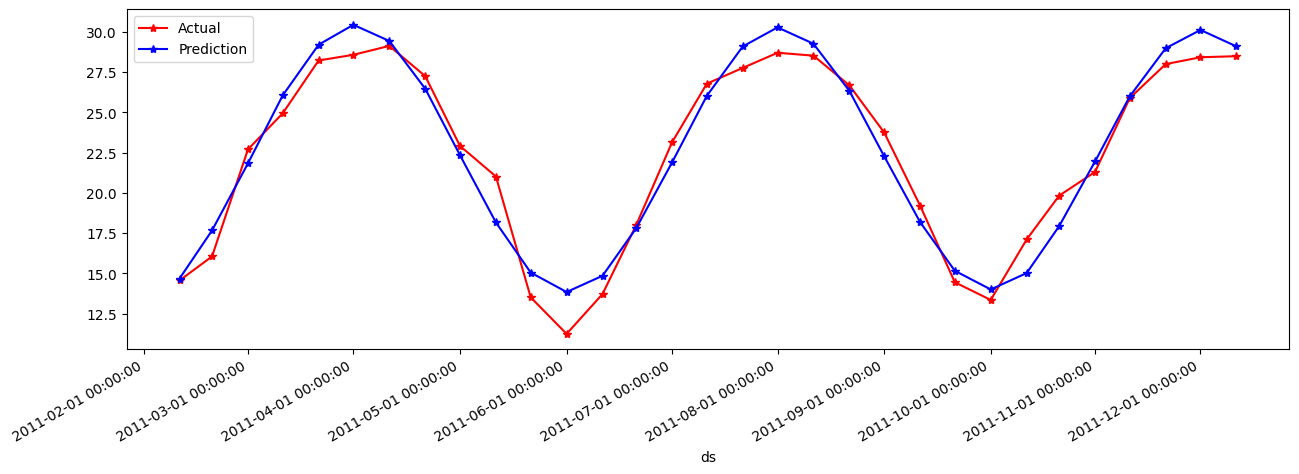

In [87]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test2.index, test2['y'], color='r',marker='*',label='Actual')
pred.plot(ax=ax,color='b',marker='*',label='Prediction')
ax.set_xticklabels(pred.index)
plt.legend()

#### Statistic Comparison

MAE: 1.1117279851710196
MAPE: 5.504%


,prediction,test,diff,diff%,dt
0,14.7,14.6,0.1,0.8,2011-02-01
1,17.7,16.1,1.6,10.1,2011-03-01
2,21.8,22.7,-0.9,-3.8,2011-04-01
3,26.1,24.9,1.1,4.5,2011-05-01
4,29.2,28.2,1.0,3.5,2011-06-01
5,30.4,28.6,1.9,6.5,2011-07-01
6,29.4,29.1,0.3,1.1,2011-08-01
7,26.5,27.3,-0.8,-2.9,2011-09-01
8,22.3,22.9,-0.6,-2.5,2011-10-01
9,18.2,21.0,-2.9,-13.6,2011-11-01


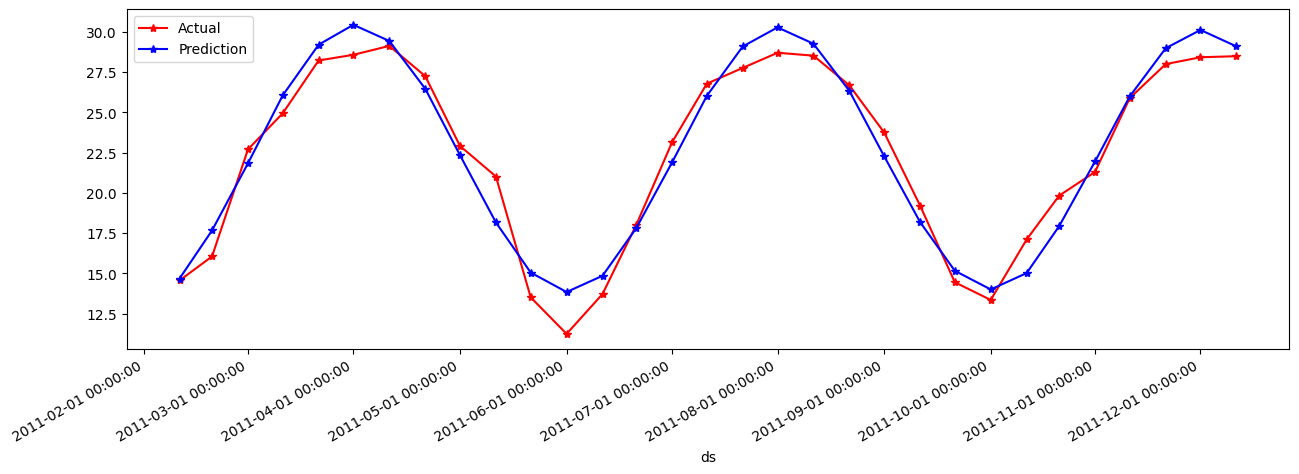

In [75]:


from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
mae_arima=mean_absolute_error(forecast[-test_size:].yhat1.values,test.y.values)
mape_arima=round(mean_absolute_percentage_error(forecast[-test_size:].yhat1.values,test.y.values)*100,3)
print('MAE: '+str(mae_arima))
print('MAPE: '+str(mape_arima)+'%')
summary_arima=pd.DataFrame({'prediction':forecast[-test_size:].yhat1.values,'test':test.y.values})
summary_arima['diff']=round(summary_arima.prediction-summary_arima.test,1)
summary_arima['diff%']=round((summary_arima.prediction-summary_arima.test)/summary_arima.test*100,1)
summary_arima['prediction']=round(summary_arima['prediction'],1)
summary_arima['test']=round(summary_arima['test'],1)
summary_arima['dt']=future['ds'][-test_size:].values
summary_arima

### SARIMAX

https://towardsdatascience.com/multi-step-time-series-forecasting-with-arima-lightgbm-and-prophet-cc9e3f95dfb0

#### Stationary Test

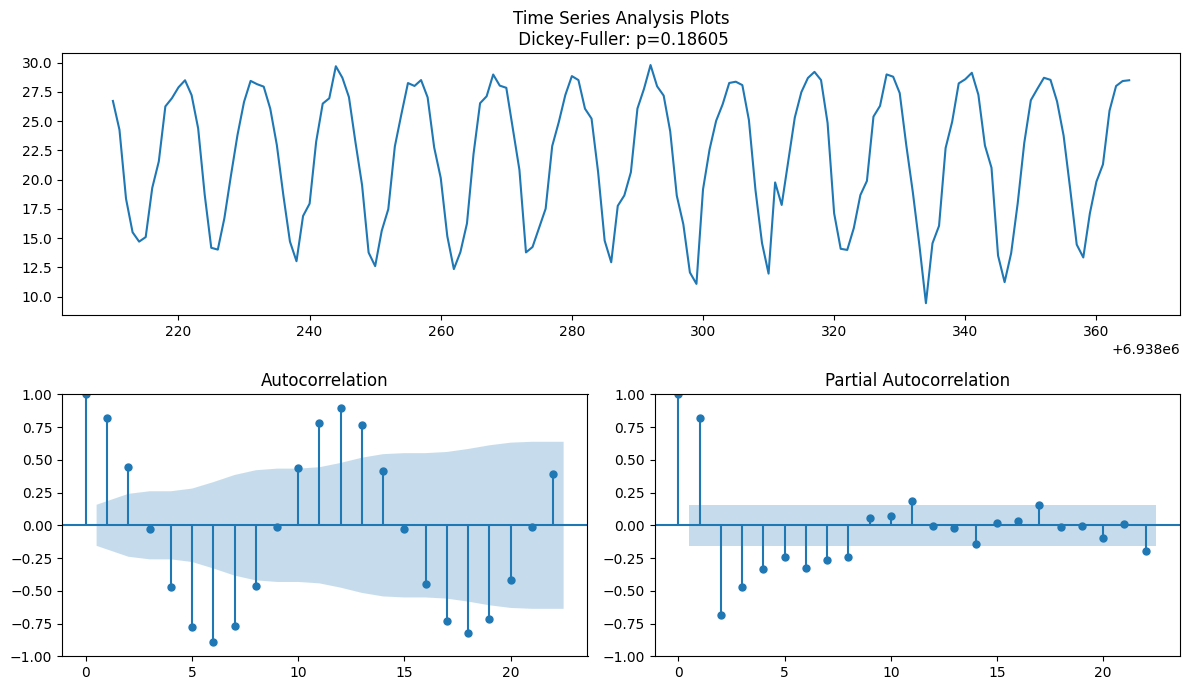

In [76]:
import statsmodels.api as sm
import statsmodels
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    statsmodels.graphics.tsaplots.plot_acf(y, lags=lags, ax=acf_ax)
    statsmodels.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()
    
tsplot(dfhk['y'])

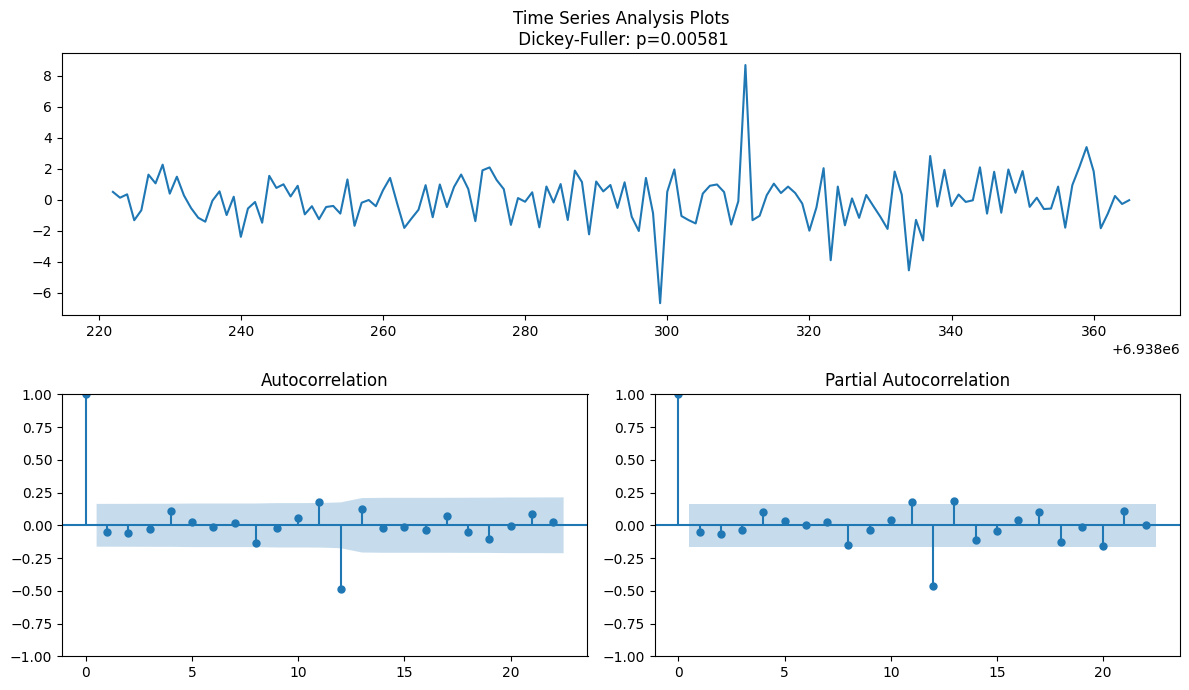

In [77]:
dfhk_lag12 = (dfhk['y'] - dfhk['y'].shift(12)).dropna()
tsplot(dfhk_lag12)

In [78]:
train_s=train.y

In [79]:
from sktime.forecasting.arima import AutoARIMA

forecaster = AutoARIMA(start_p=12, max_p=15, suppress_warnings=True)
train.index = train.index.astype(int)
forecaster.fit(train['y'])
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  125
Model:              SARIMAX(13, 0, 3)   Log Likelihood                -202.241
Date:                Wed, 17 May 2023   AIC                            440.481
Time:                        09:04:05   BIC                            491.391
Sample:                             0   HQIC                           461.163
                                - 125                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     17.6279     17.491      1.008      0.314     -16.654      51.910
ar.L1          0.1738      0.206      0.842      0.400      -0.231       0.578
ar.L2          0.0324      0.198      0.164      0.870      -0.355       0.420
ar.L3         -0.4724      0.180     -2.622      0.009      -0.826      -0.119
ar.L4          0.0778      0.153      0.509      0.611      -0.222       0.378
ar.L5          0.0222      0.154      0.144      0.885      -0.279       0.323
ar.L6         -0.1046      0.139     -0.752      0.452      -0.377       0.168
ar.L7         -0.0250      0.151     -0.165      0.869      -0.322       0.272
ar.L8         -0.2181      0.144     -1.512      0.130      -0.501       0.065
ar.L9         -0.0537      0.116     -0.464      0.643      -0.280       0.173
ar.L10         0.0943      0.161      0.586      0.558      -0.221       0.410
ar.L11         0.1495      0.133      1.124      0.261      -0.111       0.410
ar.L12         0.1562      0.107      1.453      0.146      -0.055       0.367
ar.L13         0.3662      0.151      2.432      0.015       0.071       0.661
ma.L1         -0.0006      0.212     -0.003      0.998      -0.417       0.416
ma.L2         -0.1682      0.233     -0.720      0.471      -0.626       0.289
ma.L3          0.5353      0.184      2.902      0.004       0.174       0.897
sigma2         1.3161      0.142      9.281      0.000       1.038       1.594
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                90.57
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.35   Skew:                             0.25
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Visual Comparison

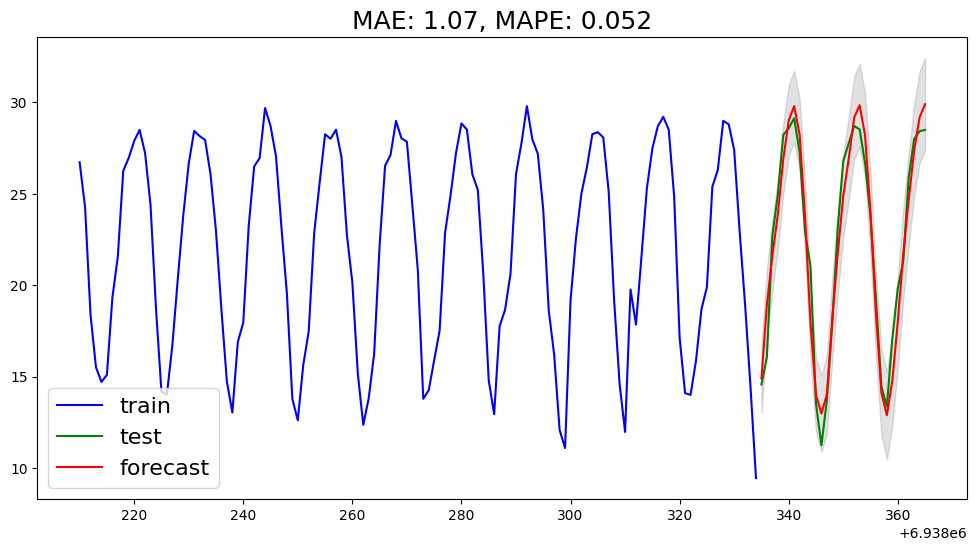

In [80]:
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


def plot_forecast(series_train, series_test, forecast, forecast_int=None):

    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)

    plt.figure(figsize=(12, 6))
    plt.title(f"MAE: {mae:.2f}, MAPE: {mape:.3f}", size=18)
    series_train.plot(label="train", color="b")
    series_test.plot(label="test", color="g")
    forecast.index = series_test.index
    forecast.plot(label="forecast", color="r")
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.show()

    return mae, mape

fh = np.arange(test_size) + 1
forecast = forecaster.predict(fh=fh)
coverage = 0.9 # confidence interval
forecast_int = forecaster.predict_interval(fh=fh, coverage=coverage)['Coverage'][coverage]
sun_arima_mae, sun_arima_mape = plot_forecast(
    train.y, test.y, forecast, forecast_int
)


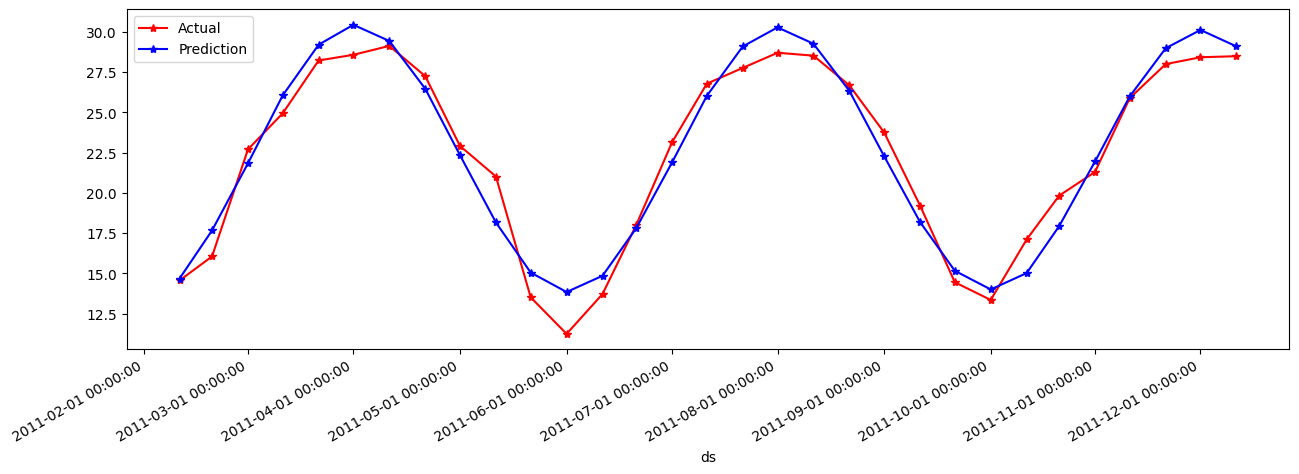

In [88]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test2.index, test2['y'], color='r',marker='*',label='Actual')
pred.plot(ax=ax,color='b',marker='*',label='Prediction')
ax.set_xticklabels(pred.index)
plt.legend()

#### Statistic Comparison

MAE: 1.0742044693283659
MAPE: 5.24%


,prediction,test,diff,diff%,dt
0,14.9,14.6,0.3,2.3,2011-02-01
1,18.9,16.1,2.9,18.0,2011-03-01
2,21.6,22.7,-1.1,-4.8,2011-04-01
3,23.9,24.9,-1.1,-4.4,2011-05-01
4,26.9,28.2,-1.3,-4.7,2011-06-01
5,29.0,28.6,0.4,1.5,2011-07-01
6,29.8,29.1,0.7,2.3,2011-08-01
7,28.2,27.3,1.0,3.6,2011-09-01
8,23.7,22.9,0.8,3.6,2011-10-01
9,17.9,21.0,-3.1,-14.9,2011-11-01


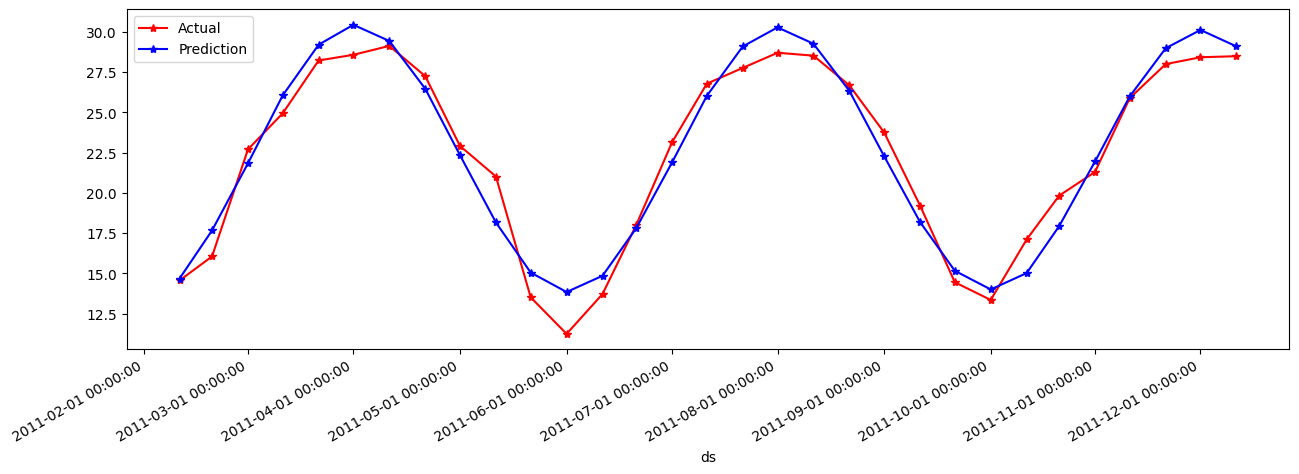

In [81]:
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
mae_sarimax=mean_absolute_error(forecast[-test_size:].values,test.y.values)
mape_sarimax=round(mean_absolute_percentage_error(forecast[-test_size:].values,test.y.values)*100,3)
print('MAE: '+str(mae_sarimax))
print('MAPE: '+str(mape_sarimax)+'%')
summary_sarimax=pd.DataFrame({'prediction':forecast[-test_size:].values,'test':test.y.values})
summary_sarimax['diff']=round(summary_sarimax.prediction-summary_sarimax.test,1)
summary_sarimax['diff%']=round((summary_sarimax.prediction-summary_sarimax.test)/summary_sarimax.test*100,1)
summary_sarimax['prediction']=round(summary_sarimax['prediction'],1)
summary_sarimax['test']=round(summary_sarimax['test'],1)
summary_sarimax['dt']=future['ds'][-test_size:].values
summary_sarimax

## Light GBM

best params: {'window_length': 29}


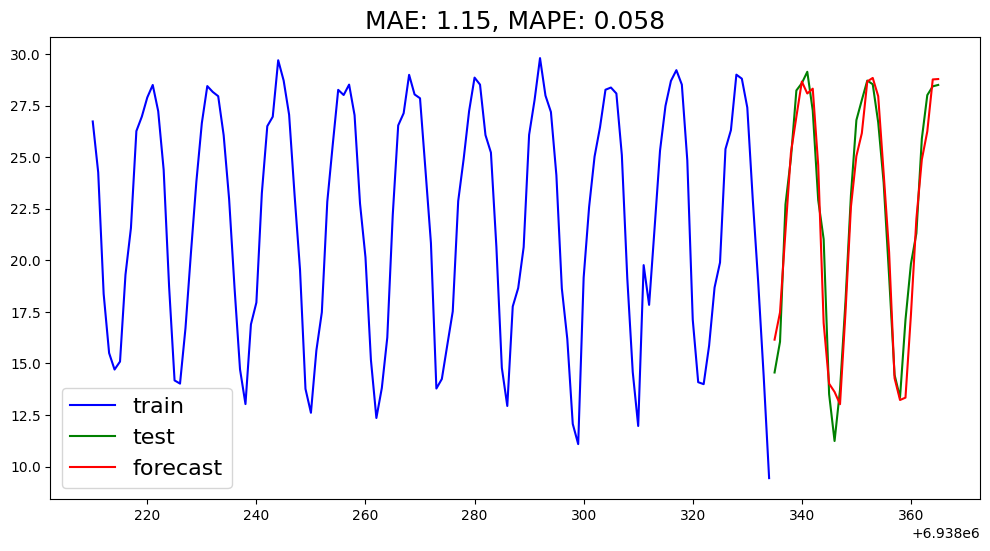

In [82]:
def plot_forecast(series_train, series_test, forecast, forecast_int=None):

    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)

    plt.figure(figsize=(12, 6))
    plt.title(f"MAE: {mae:.2f}, MAPE: {mape:.3f}", size=18)
    series_train.plot(label="train", color="b")
    series_test.plot(label="test", color="g")
    forecast.index = series_test.index
    forecast.plot(label="forecast", color="r")
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.show()

    return mae, mape

from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
import lightgbm as lgb

def create_forecaster():

    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor()
    forecaster = make_reduction(regressor, window_length=5, strategy="recursive")

    return forecaster


#### Hyper-parameter tuning

In [ ]:
def grid_serch_forecaster(train, test, forecaster, param_grid):

    # Grid search on window_length
    cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))
    gscv = ForecastingGridSearchCV(
        forecaster, strategy="refit", cv=cv, param_grid=param_grid, 
        scoring=MeanAbsolutePercentageError(symmetric=True)
    )
    gscv.fit(train)
    print(f"best params: {gscv.best_params_}")

    # forecasting
    fh = np.arange(len(test)) + 1
    y_pred = gscv.predict(fh=fh)
    mae, mape = plot_forecast(train, test, y_pred)

    return mae, mape


param_grid = {
    "window_length": [28,29,30,31,32] # parameter set to be grid searched
}
forecaster = create_forecaster()
lgb_mae, lgb_mape = grid_serch_forecaster(
    train.y, test.y, forecaster, param_grid
)

#### Visual Comparison

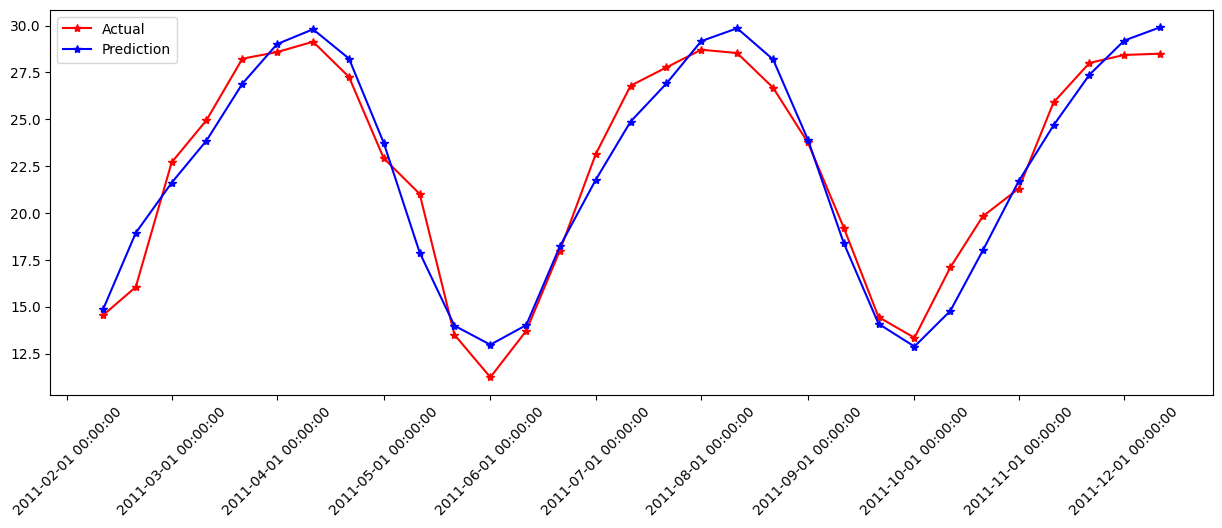

In [83]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test['ds'], test.y, color='r',marker='*',label='Actual')
ax.plot(dfhk['ds'][-test_size:],forecast.values,color='b',marker='*',label='Prediction')
ax.set_xticklabels(test['ds'])
plt.xticks(rotation=45)
plt.legend()

#### Statistic Comparison

In [84]:
mae_lgb=lgb_mae
mape_lgb=round(lgb_mape*100,3)
print('MAE: '+str(lgb_mae))
print('MAPE: '+str(round(lgb_mape*100,3))+'%')
summary_lgbm=pd.DataFrame({'prediction':forecast[-test_size:].values,'test':test.y.values})
summary_lgbm['diff']=round(summary_lgbm.prediction-summary_lgbm.test,1)
summary_lgbm['diff%']=round((summary_lgbm.prediction-summary_lgbm.test)/summary_lgbm.test*100,1)
summary_lgbm['prediction']=round(summary_lgbm['prediction'],1)
summary_lgbm['test']=round(summary_lgbm['test'],1)
summary_lgbm['dt']=future['ds'][-test_size:].values
summary_lgbm

MAE: 1.150942496932297
MAPE: 5.787%


,prediction,test,diff,diff%,dt
0,14.9,14.6,0.3,2.3,2011-02-01
1,18.9,16.1,2.9,18.0,2011-03-01
2,21.6,22.7,-1.1,-4.8,2011-04-01
3,23.9,24.9,-1.1,-4.4,2011-05-01
4,26.9,28.2,-1.3,-4.7,2011-06-01
5,29.0,28.6,0.4,1.5,2011-07-01
6,29.8,29.1,0.7,2.3,2011-08-01
7,28.2,27.3,1.0,3.6,2011-09-01
8,23.7,22.9,0.8,3.6,2011-10-01
9,17.9,21.0,-3.1,-14.9,2011-11-01


## VAR
https://towardsdatascience.com/multivariate-time-series-forecasting-456ace675971

## Multivariate ARIMA 
https://towardsdatascience.com/a-real-world-time-series-data-analysis-and-forecasting-121f4552a87

# Summary

In [85]:
conclusion=pd.DataFrame({'Prophet':[mae_prophet_before,mape_prophet_before]
                         ,'Prophet_after':[mae_prophet_after,mape_prophet_after]
                         ,'NeuralProphet':[mae_n_prophet,mape_n_prophet]
                         ,'ARIMA':[mae_arima,mape_arima]
                         ,'SARIMAX':[mae_sarimax,mape_sarimax]
                         ,'LightGBM':[mae_lgb,mape_lgb]}
                         ,index=['MAE','MAPE'])
conclusion=conclusion.transpose()
conclusion['MAPE']=conclusion['MAPE'].astype(str)+'%'
conclusion=conclusion.sort_values('MAE')
conclusion

,MAE,MAPE
Prophet_after,0.866605,4.405%
NeuralProphet,0.947471,4.889%
SARIMAX,1.074204,5.24%
ARIMA,1.111728,5.504%
Prophet,1.122327,5.557%
LightGBM,1.150942,5.787%


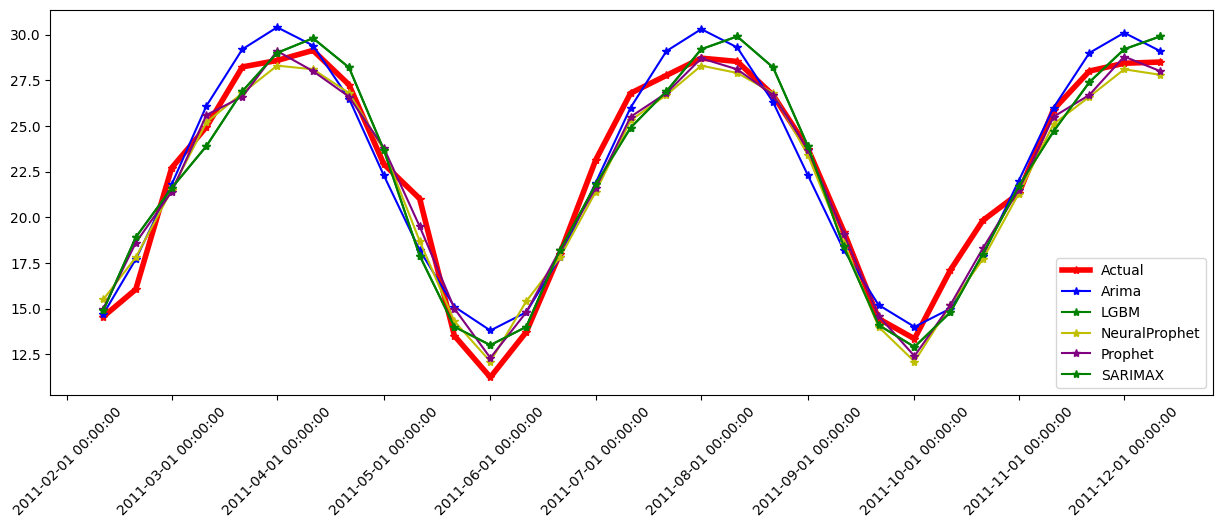

In [86]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test['ds'], test.y, color='r',lw=4,marker='*',label='Actual')
ax.plot(dfhk['ds'][-test_size:],summary_arima['prediction'],color='b',marker='*',label='Arima')
ax.plot(dfhk['ds'][-test_size:],summary_lgbm['prediction'],color='g',marker='*',label='LGBM')
ax.plot(dfhk['ds'][-test_size:],summary_n_prophet['prediction'],color='y',marker='*',label='NeuralProphet')
ax.plot(dfhk['ds'][-test_size:],summary_prophet_after['prediction'],color='purple',marker='*',label='Prophet')
ax.plot(dfhk['ds'][-test_size:],summary_sarimax['prediction'],color='green',marker='*',label='SARIMAX')
ax.set_xticklabels(test['ds'])
plt.xticks(rotation=45)
plt.legend()